In [1]:
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import os
import random
import scipy

/homes/e34960/anaconda3/envs/patchdiff/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gt_images_folder = "/project/trinity/datasets/apricot/pub/apricot-mask/data_mask_v2"
gt_images_names = os.listdir(gt_images_folder)

print(len(gt_images_names))

873


In [3]:
def compute_vectorized_iou(given_mask, masks):
    given_mask_expanded = np.expand_dims(given_mask, axis=0)
    masks_expanded = np.stack(masks)
    intersection = np.logical_and(masks_expanded > 0, given_mask_expanded > 0)
    union = np.logical_or(masks_expanded > 0, given_mask_expanded > 0)
    intersection_sum = np.sum(intersection, axis=(1, 2))
    union_sum = np.sum(union, axis=(1, 2))
    iou_values = intersection_sum / union_sum
    return iou_values

def getRandomImages(n=1):
    random_numbers = random.sample(range(0, len(gt_images_names)-1), n)

    imgs = []
    img_masks = []
    for i in range(n):
        # idx = random.randint(0,len(gt_images_names)-1)
        img_info = torch.load(os.path.join(gt_images_folder, gt_images_names[random_numbers[i]]))
        img = np.squeeze(img_info['Image'])
        img = np.uint8(img * 255.0)
        img = cv2.resize(img, (512,512), interpolation = cv2.INTER_AREA)
        imgs.append(img)

        img_mask = np.squeeze(img_info['Mask'])
        img_mask = np.uint8(img_mask * 255.0)
        img_mask = cv2.resize(img_mask, (512,512), interpolation = cv2.INTER_AREA)
        img_masks.append(img_mask)

    return imgs, img_masks

In [4]:
sam = sam_model_registry["vit_h"](checkpoint="/project/trinity/pretrained_models/sam_facebook/sam_vit_h_4b8939.pth")
sam.to(device='cuda:1')
mask_generator = SamAutomaticMaskGenerator(sam)

In [6]:
def runAll(numImages, thresholdDCT, thresholdSegmentArea, showImages=False):
    num_images = numImages
    img_list, mask_list = getRandomImages(num_images)

    # frequency_band_percentage = frequencyBandPercentage
    img_size = img_list[0].shape[0]
    img_area = img_size * img_size

    # If a segment is smaller than 0.5%, it will be discarded
    threshold_segment_area = thresholdSegmentArea

    patch_indices = []

    top_images_to_display = 5

    for i in range(num_images):
        masks = mask_generator.generate(img_list[i])
        all_masks = []
        for z, meta_info in enumerate(masks):
            all_masks.append(meta_info['segmentation'])

        iou_vals = compute_vectorized_iou(mask_list[i], all_masks)
        patch_mask_idx = np.argmax(iou_vals)

        masked_img_list = []
        dct_grayscale_list = []
        dct_rgb_list = []
        max_frequencies_list = []

        stability_scores = []
        predicted_ious = []

        new_patch_mask_idx = 0
        current_iter = -1

        for j in range(len(masks)):
            current_mask = masks[j]['segmentation']

            if (j == patch_mask_idx) or (np.sum(current_mask == 1) >= img_area * threshold_segment_area):
                current_iter += 1

                mask_3d = np.repeat(current_mask[:, :, np.newaxis], 3, axis=2)
                masked_img = img_list[i] * mask_3d
                masked_img_list.append(masked_img)

                # Grayscale DCT
                gray_scale = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
                dct_grayscale = scipy.fftpack.dct( scipy.fftpack.dct(gray_scale, axis=0, norm='ortho' ), axis=1, norm='ortho' )
                magnitude_spectrum_grayscale = np.abs(dct_grayscale)
                dct_grayscale_list.append(np.log(magnitude_spectrum_grayscale + 1))

                # RGB DCT
                dct_rgb = scipy.fftpack.dct( scipy.fftpack.dct(masked_img, axis=0, norm='ortho' ), axis=1, norm='ortho' )
                magnitude_spectrum_rgb = np.abs(dct_rgb)
                dct_rgb_list.append(np.log(magnitude_spectrum_rgb + 1))
                
                if j < patch_mask_idx:
                    new_patch_mask_idx += 1

                stability_scores.append(masks[j]['stability_score'])
                predicted_ious.append(masks[j]['predicted_iou'])

                # top_row = int(img_size - img_size * (1.0 - frequency_band_percentage / 2.0))
                # bottom_row = int(img_size - img_size * frequency_band_percentage / 2.0)

                # Band of frequencies for Grayscale images
                max_frequencies_list.append(np.sum(dct_grayscale_list[current_iter] > thresholdDCT))
        

        # Normalization
        dct_grayscale_list = np.stack(dct_grayscale_list, axis=-1)
        dct_grayscale_list = 255.0 * (dct_grayscale_list - np.min(dct_grayscale_list)) / (np.max(dct_grayscale_list) - np.min(dct_grayscale_list))
        
        dct_rgb_list = np.stack(dct_rgb_list, axis=-1)
        dct_rgb_list = 255.0 * (dct_rgb_list - np.min(dct_rgb_list)) / (np.max(dct_rgb_list) - np.min(dct_rgb_list))

        # Sum over the higher frequencies (defined by frequency band percentage) for ranking the segments
        # max_frequencies_list = np.sum(dct_grayscale_list, axis=(0,1)) - np.sum(dct_grayscale_list[top_row:bottom_row, top_row:bottom_row, :], axis=(0,1))


        # Highest Frequency for the patch mask
        patch_mask_freq = max_frequencies_list[new_patch_mask_idx]

        max_frequencies_list = np.array(max_frequencies_list)
        sorted_max_frequencies_list = np.sort(max_frequencies_list)[::-1]
        sorted_indices = np.argsort(max_frequencies_list)[::-1]

        patch_indices.append(np.where(sorted_max_frequencies_list == patch_mask_freq)[0][0])
 
        if showImages:
            plt.figure(figsize=(5,4))
            plt.imshow(img_list[i])
            # plt.title('Original Image')
            plt.axis('off')
            plt.show()

            ##### Plot top 4 frequencies and the adversarial patch frequency (magnitude spectrum)

            fig, axes = plt.subplots(nrows=5, ncols=top_images_to_display, figsize=(30, 24))
            for k in range(top_images_to_display):
                if k != top_images_to_display - 1:
                    axes[0][k].imshow(masked_img_list[sorted_indices[k]], cmap='gray')
                    axes[0][k].set_title('Top {} frequency component'.format(k+1))
                    axes[0][k].axis('off')

                    axes[1][k].imshow(dct_grayscale_list[:,:,sorted_indices[k]], cmap='gray')
                    axes[1][k].set_title('DCT Grayscale')
                    axes[1][k].axis('off')

                    axes[2][k].imshow(dct_rgb_list[:,:,0,sorted_indices[k]], cmap='gray')
                    axes[2][k].set_title('DCT R-Channel')
                    axes[2][k].axis('off')

                    axes[3][k].imshow(dct_rgb_list[:,:,1,sorted_indices[k]], cmap='gray')
                    axes[3][k].set_title('DCT G-Channel')
                    axes[3][k].axis('off')

                    axes[4][k].imshow(dct_rgb_list[:,:,2,sorted_indices[k]], cmap='gray')
                    axes[4][k].set_title('DCT B-Channel')
                    axes[4][k].axis('off')


                else:
                    axes[0][k].imshow(masked_img_list[new_patch_mask_idx], cmap='gray')
                    axes[0][k].set_title('Adversarial patch')
                    axes[0][k].axis('off')

                    axes[1][k].imshow(dct_grayscale_list[:,:,new_patch_mask_idx], cmap='gray')
                    axes[1][k].set_title('DCT')
                    axes[1][k].axis('off')

                    axes[2][k].imshow(dct_rgb_list[:,:,0,new_patch_mask_idx], cmap='gray')
                    axes[2][k].set_title('DCT R-Channel')
                    axes[2][k].axis('off')

                    axes[3][k].imshow(dct_rgb_list[:,:,1,new_patch_mask_idx], cmap='gray')
                    axes[3][k].set_title('DCT G-Channel')
                    axes[3][k].axis('off')

                    axes[4][k].imshow(dct_rgb_list[:,:,2,new_patch_mask_idx], cmap='gray')
                    axes[4][k].set_title('DCT B-Channel')
                    axes[4][k].axis('off')
            
            plt.tight_layout()
            plt.show()
    
    return patch_indices

In [7]:
numImages = 20
thresholdDCT = 3  # Since most of the coefficients are close to 0, after taking log(1+x) and checking the magnitude of coefficient, we won't consider it if it is less than this threshold
thresholdSegmentArea = 0.005 # 0.5 % 

patch_indices = runAll(numImages, thresholdDCT, thresholdSegmentArea, showImages=True)


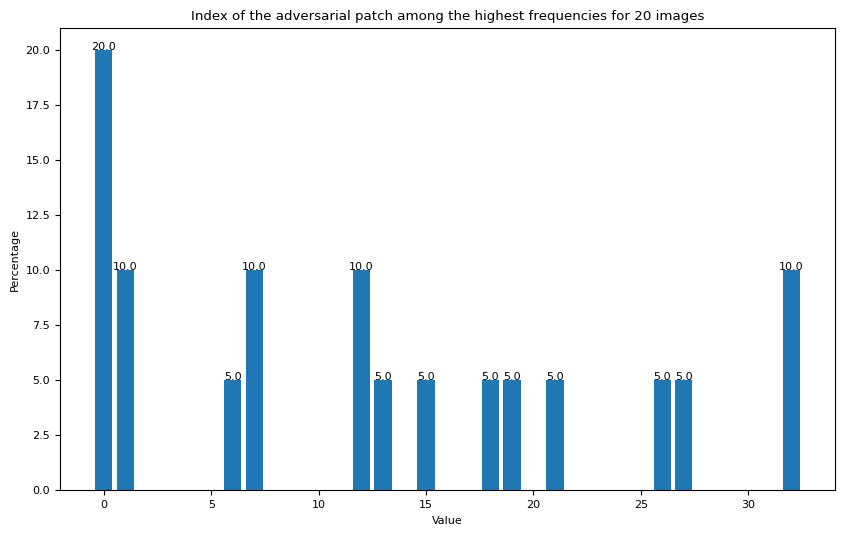

In [15]:
hist, bins = np.histogram(patch_indices, bins=np.arange(np.max(patch_indices) + 1))

plt.figure(figsize=(10,6))
plt.rc('font', size=8)

percentage = hist / len(patch_indices) * 100

# Plot the percentage-wise histogram
plt.bar(bins[:-1], percentage, align='center', width=0.8)
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Index of the adversarial patch among the highest frequencies for {} images'.format(numImages))

for i in range(len(percentage)):
    if percentage[i] != 0.0:
        plt.text(bins[i], percentage[i], f'{percentage[i]:.1f}', ha='center')

plt.show()

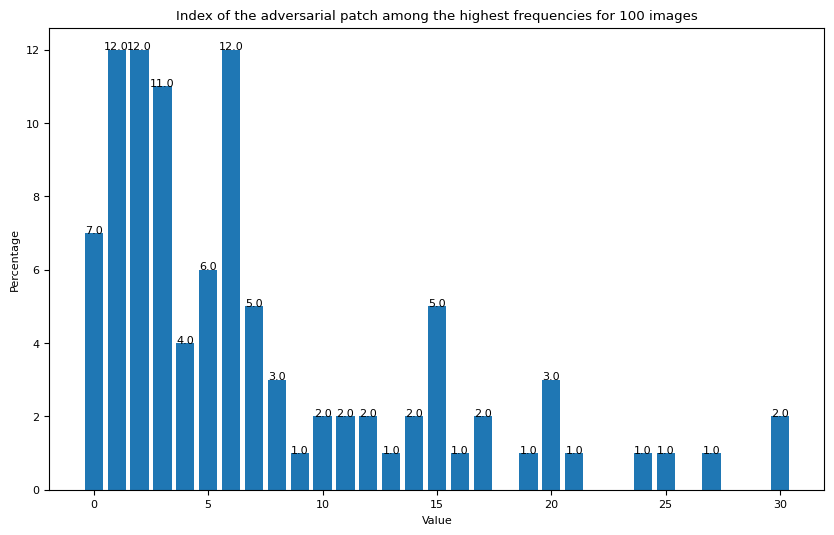

In [16]:
numImages = 100
thresholdDCT = 2  # Since most of the coefficients are close to 0, after taking log(1+x) and checking the magnitude of coefficient, we won't consider it if it is less than this threshold
thresholdSegmentArea = 0.005 # 0.5 % 

patch_indices = runAll(numImages, thresholdDCT, thresholdSegmentArea)

hist, bins = np.histogram(patch_indices, bins=np.arange(np.max(patch_indices) + 1))

plt.figure(figsize=(10,6))
plt.rc('font', size=8)

percentage = hist / len(patch_indices) * 100

# Plot the percentage-wise histogram
plt.bar(bins[:-1], percentage, align='center', width=0.8)
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Index of the adversarial patch among the highest frequencies for {} images'.format(numImages))

for i in range(len(percentage)):
    if percentage[i] != 0.0:
        plt.text(bins[i], percentage[i], f'{percentage[i]:.1f}', ha='center')

plt.show()